## Code to analyze the popular Blackjack sidebet game, the Lucky Ladies. The Lucky Ladies pay out according to the pay table below
1. Queen of hearts pair and dealer has bj (1000 to 1)
2. Queen of hearts pair (200 to 1)
3. Matched 20 (25 to 1)
4. Suited 20 (10 to 1)
5. Unsuited 20 (4 to 1)

In [1]:
import pandas as pd
import numpy as np
from random import shuffle
from blackjack_sidebet_sim import Blackjack_shoe
import os
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets, ensemble
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
cards = ['ace','king','queen','jack','ten','nine','eight','seven','six','five','four','three','two']
suits = ['spades','hearts','clubs','diamonds']

In [3]:
card_values = {'ace':11,'king':10,'queen':10,'jack':10,'ten':10,'nine':9,'eight':8,\
           'seven':7,'six':6,'five':5,'four':4,'three':3,'two':2}

In [4]:
counting_df = pd.read_csv(os.getcwd()+'/counting_systems/high_low_blackjack.csv').drop(['Unnamed: 0'],axis=1)
counting_df.head()

,Card,Value
0,ace_of_spades,-1
1,ace_of_hearts,-1
2,ace_of_clubs,-1
3,ace_of_diamonds,-1
4,king_of_spades,-1


In [5]:
counting_rules = dict(zip(counting_df.Card, counting_df.Value))
small_cards = counting_df[counting_df['Value']>0].Card.tolist()

In [6]:
run_sims_flag = False
num_sims = 100000
cost_to_play = 5
avg_rt = num_sims*30/3600 #assume 60 seconds/hand in real life. 

In [7]:
if run_sims_flag == True: 
    num_decks_list = [8,7,6,5,4,3,2,1]
    matrix = []
    for num_decks in num_decks_list: 
        data = []
        expectation = -1*num_sims*cost_to_play
        for running_count in range(4*5*num_decks):  
            shoe = Blackjack_shoe(num_decks_remaining=num_decks,running_count=running_count,\
                            counting_rules=counting_rules,small_cards=small_cards,win_counter=0)        
            for j in range(num_sims): 
                shoe.create_shoe()
                shoe.establish_count()
                shoe.evaluate_lucky_ladies(card_values=card_values)
            shoe.summarize_money_won()
            money_won,true_count = shoe.get_money_won()
            data = [num_decks,running_count,money_won,true_count]
            matrix.append(data)
    df = pd.DataFrame(matrix,columns = ['num_decks_remaining','running_count','expected_value','true_count'])
    df.to_csv(os.getcwd()+'/Results/lucky_ladies_sim_results.csv')
    df.head()

In [8]:
df = pd.read_csv(os.getcwd()+'/Results/lucky_ladies_sim_results.csv').drop(['Unnamed: 0'],axis=1)
df = df[df['num_decks_remaining']!=1]
df['avg (dollars/hour)'] =  df['expected_value']/avg_rt
df.head()

,num_decks_remaining,running_count,expected_value,true_count,avg (dollars/hour)
0,8,0,-89320,0.000000,-107.184
1,8,1,-71495,0.125301,-85.794
2,8,2,-81780,0.251208,-98.136
3,8,3,-72615,0.377724,-87.138
4,8,4,-75360,0.504854,-90.432


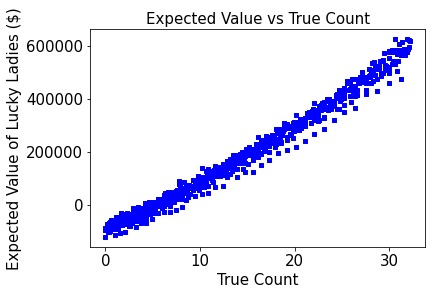

In [9]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(df['true_count'], df['expected_value'], s=20, c='b', marker="s")
ax1.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Expected Value of Lucky Ladies ($)',fontsize=15)
plt.xlabel('True Count',fontsize=15)
plt.title('Expected Value vs True Count',fontsize=15)
plt.show()

## This analysis is perfect if we are constantly playing the game at these conditions. We must multiply the expected value by the frequency with which these conditions occur.

In [10]:
num_decks=6
running_count = 0
freq_list = []
num_sims = 1000
time_to_finish_all_shoes = 20*num_sims / 60 # (in hours)
for i in range(0,num_sims):
    shoe = Blackjack_shoe(num_decks_remaining=num_decks,running_count=running_count,\
                counting_rules=counting_rules,small_cards=small_cards,win_counter=0)  
    shoe.create_shoe()
    freq_list = freq_list + shoe.simulate_blackjack_shoe(0.95)

In [11]:
#Simulate game num_sims times and aggregate true count situations. 
freq_df = pd.DataFrame(freq_list,columns = ['num_decks_remaining','running_count'])
freq_df['true_count'] = freq_df['running_count'] / freq_df['num_decks_remaining']
freq_df.head()

,num_decks_remaining,running_count,true_count
0,6,2,0.333333
1,6,9,1.500000
2,6,16,2.666667
3,6,11,1.833333
4,6,11,1.833333


In [12]:
#Use value_counts to compute frequency with which these situations occur. 
freq_df = pd.DataFrame(freq_df.true_count.value_counts()).reset_index()
freq_df.columns = ['true_count','frequency']
freq_df.head()

,true_count,frequency
0,0.0,1995
1,-1.0,1590
2,1.0,1537
3,-2.0,1114
4,2.0,1057


In [13]:
#Convert to fraction of hour. 
freq_df['Fraction_of_hour'] = freq_df['frequency'] /freq_df['frequency'].sum()
freq_df.head()

,true_count,frequency,Fraction_of_hour
0,0.0,1995,0.066500
1,-1.0,1590,0.053000
2,1.0,1537,0.051233
3,-2.0,1114,0.037133
4,2.0,1057,0.035233


In [14]:
df.head()

,num_decks_remaining,running_count,expected_value,true_count,avg (dollars/hour)
0,8,0,-89320,0.000000,-107.184
1,8,1,-71495,0.125301,-85.794
2,8,2,-81780,0.251208,-98.136
3,8,3,-72615,0.377724,-87.138
4,8,4,-75360,0.504854,-90.432


In [15]:
X = df[['true_count']]
y = df[['avg (dollars/hour)']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [16]:
reg = LinearRegression()

In [ ]:
reg.fit(X_train, y_train)
#y_pred = reg.predict(X_test).tolist()

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(X_test.true_count, y_pred, s=20, c='b', marker="s", label='Prediction')
ax1.scatter(X_test.true_count,y_test, s=20, c='r', marker="o", label='Actual')
ax1.tick_params(axis='both', which='major', labelsize=15)
plt.legend(loc='upper left',fontsize=15)
plt.ylabel('Expected Hourly wage ($/Hour)',fontsize=15)
plt.xlabel('True Count',fontsize=15)
plt.show()

In [ ]:
#Compute the expected hourly value, weighted by positive shoes. 
true_count_list = freq_df.true_count.tolist()
true_count_list = np.array(true_count_list).reshape(-1, 1)
model_results = reg.predict(true_count_list).tolist()
res = pd.DataFrame({'true_count':freq_df.true_count.tolist(),'Predicted_hourly_rate':[item for sublist in model_results for item in sublist]})
res = res.merge(freq_df,left_on='true_count',right_on='true_count',how='inner')
res = res[res['Predicted_hourly_rate']>0]
val = np.sum(np.multiply(res.Predicted_hourly_rate,res.Fraction_of_hour))
val

## We will only be making about $2/hour under these conditions... not great. Lucky Ladies requires very high true count to become a profitable bet (TC>5.5 according to this data), something that only occurs ~2% of the time. This game can be played sparingly (only extremely high true counts) while simultaneously playing a positive expected value game of blackjack.